In [44]:
# A basic time series analysis script.
# The script reads in a csv, formats the date field, and runs the data through the Facebook Prophet forecasting algorithm.
# The following is adapted from an ETL workflow I put in place to pull down data, run a series of analytical models, and then load
# the finalized data into a Tableau dashboard.

In [44]:
# import your standard stats libraries libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [45]:
# load the dataset
dataset = pd.read_csv('volume_data.csv')
dataset.head()

,Product Sum,Week,TRx
0,AMITIZA,7/27/18,26569
1,AMITIZA,7/20/18,26700
2,AMITIZA,7/13/18,27334
3,AMITIZA,7/6/18,26049
4,AMITIZA,6/29/18,27160


In [46]:
# Convert Week to datetime
if dataset['Week'].dtypes == 'O':
    dataset['Week'] = pd.to_datetime(dataset['Week'], format='%m/%d/%y')
dataset.head()

,Product Sum,Week,TRx
0,AMITIZA,2018-07-27,26569
1,AMITIZA,2018-07-20,26700
2,AMITIZA,2018-07-13,27334
3,AMITIZA,2018-07-06,26049
4,AMITIZA,2018-06-29,27160


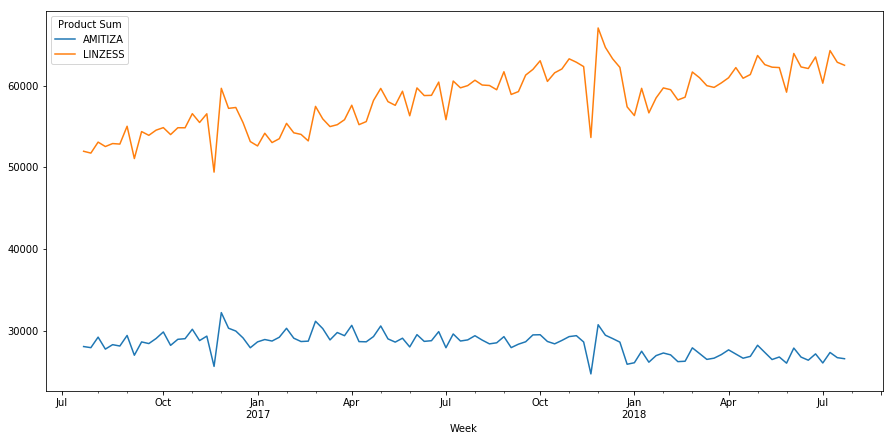

In [47]:
# Group the data by week and product, then unstack it so it can be properly graphed along a multi-line time series.
fig, ax = plt.subplots(figsize=(15,7))
dataset.groupby(['Week', 'Product Sum']).sum()['TRx'].unstack().plot(ax=ax)


In [48]:
# Forecasting for PRODUCT A using FBProphet (univariate)
# Prophet requires a 'ds' and 'y' field names.
proda_data = dataset[dataset['Product Sum'] == 'PRODUCT A'].drop(['Product Sum'], axis = 1)
proda_data = ami_data.rename(index=str, columns={'Week': 'ds', 'TRx':'y'})
proda_data.head(5)

,ds,y
0,2018-07-27,26569
1,2018-07-20,26700
2,2018-07-13,27334
3,2018-07-06,26049
4,2018-06-29,27160


In [49]:
# fit the model
from fbprophet import Prophet
m = Prophet(weekly_seasonality=True)
m.fit(proda_data)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/josh/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [50]:
# create entries for next year of data
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
466,2019-07-23
467,2019-07-24
468,2019-07-25
469,2019-07-26
470,2019-07-27


In [51]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
466,2019-07-23,24193.689071,23021.012544,25393.249493
467,2019-07-24,24166.604104,22949.477745,25428.453545
468,2019-07-25,24133.555533,22921.714672,25343.362422
469,2019-07-26,24354.330358,23139.707853,25574.340159
470,2019-07-27,24053.400820,22812.770960,25247.810869


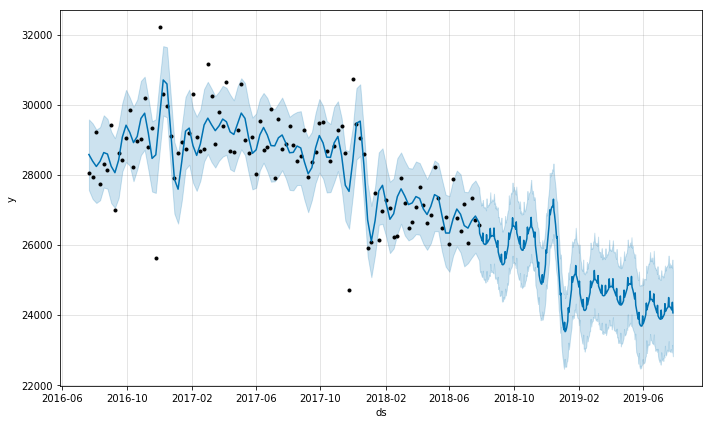

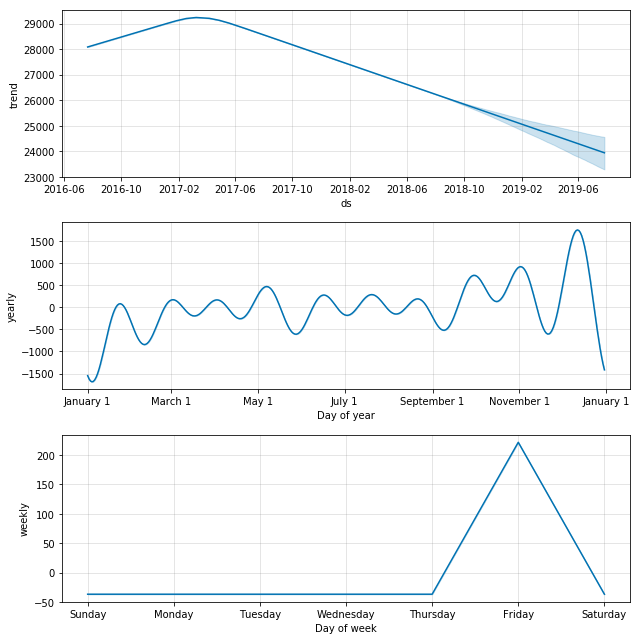

In [52]:
# make sure everything looks alright
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [53]:
# the following exports the original dataset to Tableau.
# call the Tableau API
from tableausdk import *
from tableausdk.HyperExtract import *

In [56]:
# create the Tableau extract, if it does not already exist
# NOTE: Tableau API does not have a clear() command, and will append any future data.

filename = 'dataset.hyper'
extract = Extract(filename)

# define the table schema
if (not extract.hasTable('Extract')):
    schema = TableDefinition()
    schema.setDefaultCollation(Collation.EN_US)
    schema.addColumn('Product Sum', Type.CHAR_STRING)
    schema.addColumn('Week', Type.DATE)
    schema.addColumn('TRx', Type.DOUBLE)
    table = extract.addTable('Extract', schema)

In [57]:
table = extract.openTable( 'Extract' )
schema = table.getTableDefinition()

# populate the extract with the dataset
for i in range(0, dataset.shape[0]):
    row = Row(schema)
    row.setCharString(0, dataset.iloc[i, 0])
    row.setDate(1, dataset.iloc[i, 1].year, dataset.iloc[i, 1].month, dataset.iloc[i, 1].day)
    row.setDouble(2, dataset.iloc[i, 2])
    table.insert(row)

# close the extract
extract.close()

print('process complete')

complete
